#### data dictionary for confusing entries
lobbytype_id: https://github.com/odota/dotaconstants/blob/master/json/lobby_type.json  
gamemode: https://github.com/odota/dotaconstants/blob/master/json/game_mode.json

In [1]:
import pymongo

In [2]:
import gzip
import pandas as pd
import numpy as np
import os
import json
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data_path = 'data/raw/yasp-dump-2015-12-18.json.gz'

In [15]:
try:
    client = pymongo.MongoClient()
except:
    print("connection to database failed")

In [22]:
client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [23]:
client.list_database_names()

['admin', 'config', 'local']

In [49]:
db = client['dota_matches']

In [50]:
collection = db['matches']

In [51]:
collection.create_index('match_id', unique=True)

'match_id_1'

In [53]:
collection.create_index('fake_idx')

'fake_idx_1'

In [57]:
collection.index_information()

{'_id_': {'v': 2, 'key': [('_id', 1)]},
 'match_id_1': {'v': 2, 'key': [('match_id', 1)], 'unique': True}}

In [30]:
db.list_collection_names()

[]

In [21]:
client.close()

## EDA
cruising the landscape of some problem space

In [32]:
def prepare_sample_data(raw_data_path, N = 10):
    fh = gzip.open(raw_data_path, mode = 'rt')
    rows = []
    counter = 0
    while counter < N:
        line = fh.readline()
        if line != ',\n' and line != '[\n' and line != '\n]':
            counter += 1
            parsed_line = json.loads(line)
            
            # TODO customize parsing
            # right now load everything
            rows.append(parsed_line)
    return rows

In [59]:
fh = gzip.open(data_path, mode = 'rt')

In [33]:
rows = prepare_sample_data(data_path, N=5000)

In [34]:
sample_df = pd.DataFrame(rows)

In [35]:
sample_df.shape

(5000, 27)

In [36]:
sample_df.head()

,match_id,match_seq_num,radiant_win,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire,cluster,...,engine,picks_bans,parse_status,chat,objectives,radiant_gold_adv,radiant_xp_adv,teamfights,version,players
0,2001400694,1765192504,True,1450069239,898,2047,2046,63,63,121,...,1,None,2,"[{'time': 289, 'type': 'chat', 'unit': 'DuckDy...","[{'time': 84, 'type': 'CHAT_MESSAGE_FIRSTBLOOD...","[0, 0, 0, 0, 0, 0, 0, 96, -670, -1041, -1289, ...","[0, 0, 0, 0, 0, 0, 0, 61, -664, -974, -837, -1...","[{'start': 363, 'end': 413, 'last_death': 398,...",15,"[{'account_id': 124238143, 'player_slot': 0, '..."
1,2001394362,1765193128,True,1450068932,1390,1983,256,63,48,122,...,1,None,2,"[{'time': 1391, 'type': 'chat', 'unit': 'Vices...","[{'time': 2, 'type': 'CHAT_MESSAGE_FIRSTBLOOD'...","[0, 0, 0, 0, 0, 1471, 2122, 2255, 2559, 3135, ...","[0, 0, 0, 0, 0, 797, 1004, 893, 1087, 860, 132...","[{'start': -12, 'end': 28, 'last_death': 13, '...",15,"[{'account_id': 67923911, 'player_slot': 0, 'h..."
2,2001390473,1765190770,False,1450068753,1569,0,2047,0,63,111,...,1,None,2,[],"[{'time': 143, 'type': 'chat_event', 'subtype'...","[0, -226, -313, -927, -1070, -1470, -1923, -25...","[0, -192, -223, -640, -691, -878, -1188, -1709...","[{'start': 528, 'end': 574, 'last_death': 559,...",15,"[{'account_id': None, 'player_slot': 0, 'hero_..."
3,2001390318,1765192183,True,1450068725,1630,2047,256,63,48,122,...,1,None,2,"[{'time': 1633, 'type': 'chat', 'unit': 'slipf...","[{'time': 2, 'type': 'CHAT_MESSAGE_FIRSTBLOOD'...","[0, 0, 0, 759, 991, 1815, 1996, 2629, 3975, 54...","[0, 0, 0, 443, 712, 1444, 1405, 2368, 2951, 46...","[{'start': 748, 'end': 807, 'last_death': 792,...",15,"[{'account_id': 49697610, 'player_slot': 0, 'h..."
4,2001389600,1765186247,True,1450068704,1093,2047,388,63,51,121,...,1,None,2,"[{'time': 739, 'type': 'chat', 'unit': 'Coach ...","[{'time': 138, 'type': 'CHAT_MESSAGE_FIRSTBLOO...","[0, 0, 0, 0, 0, 0, 0, -53, 174, 586, 245, 834,...","[0, 0, 0, 0, 0, 0, 0, -208, -223, -440, -701, ...","[{'start': 539, 'end': 586, 'last_death': 571,...",15,"[{'account_id': 37921758, 'player_slot': 0, 'h..."


In [115]:
sample_df.columns

Index(['match_id', 'match_seq_num', 'radiant_win', 'start_time', 'duration',
       'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant',
       'barracks_status_dire', 'cluster', 'first_blood_time', 'lobby_type',
       'human_players', 'leagueid', 'positive_votes', 'negative_votes',
       'game_mode', 'engine', 'picks_bans', 'parse_status', 'chat',
       'objectives', 'radiant_gold_adv', 'radiant_xp_adv', 'teamfights',
       'version', 'players', 'chat_len'],
      dtype='object')

#### radiant vs dire overall winrate

In [28]:
radiant_wr = sample_df['radiant_win'].mean()
dire_wr = 1-radiant_wr

<AxesSubplot:>

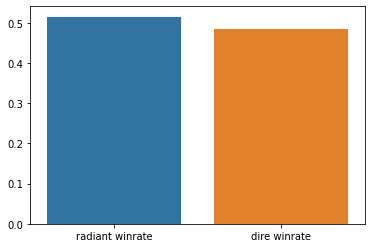

In [40]:
sns.barplot(x = ['radiant winrate', 'dire winrate'], y=[radiant_wr, dire_wr])

In [126]:
sample_df[['radiant_win', 'duration']].groupby('radiant_win').mean()

,duration
radiant_win,
False,2480.235246
True,2374.944509


In [43]:
sample_df['chat_len'] = sample_df['chat'].apply(lambda x: len(x))

<AxesSubplot:xlabel='chat_len', ylabel='Count'>

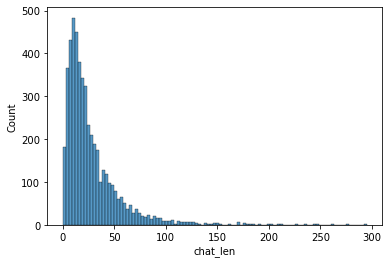

In [44]:
sns.histplot(x = sample_df['chat_len'])

There are people that talked in all chat for 100 sentences?!

In [108]:
sample_match = sample_df.loc[sample_df['chat_len'] > 200].iloc[0]

In [114]:
sample_chat_log = [entry['key'] for entry in (sample_match['chat'])]

In [69]:
len([print(chat) for chat in sample_chat_log[:5]])

:3
noob lycan
lol?
didnt kno u can take off nightmare
iwh twolf


5

In [70]:
tfidf = TfidfVectorizer()

In [72]:
tfidf_matrix = tfidf.fit_transform(sample_chat_log)

In [97]:
features = tfidf.get_feature_names()

In [95]:
# eh it's a bit messy
argmaxes = [e[0, 0] for e in np.argmax(tfidf_matrix, axis= 1)]

In [98]:
words = [features[arg] for arg in argmaxes]

In [105]:
words_freq = pd.Series(words).value_counts()

In [106]:
cloud = WordCloud().generate_from_frequencies(words_freq)

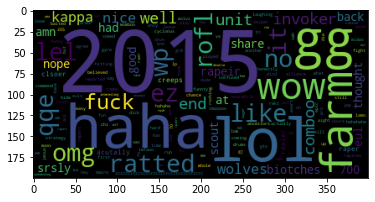

In [107]:
plt.imshow(cloud)